In [2]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
)
from datasets import Dataset
from peft import LoraConfig, inject_adapter_in_model
from transformers import EarlyStoppingCallback
from sklearn.model_selection import train_test_split

checkpoint = "./esm_mlm_cdr_pretrained_150M"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# **🔍 Load the labeled dataset (binding affinities)**
print("\n🔍 Loading labeled dataset for fine-tuning...")
file_path = "masked_affinity_sequences.csv"  # Replace with actual file path

df = pd.read_csv(file_path)

train_df = df.query('set == "train"').reset_index(drop=True)
valid_df = df.query('set == "valid"').reset_index(drop=True)

# Drop the auxiliary bin column
train_df = train_df.drop(columns=["set"])
valid_df = valid_df.drop(columns=["set"])

print(f"✅ Stratified Dataset Split: {len(train_df)} training, {len(valid_df)} validation samples.")

# 🚀 Load Pre-Trained Model for Sequence Classification
print("\n🚀 Loading pre-trained model for regression...")
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=1  # Ensure it is configured for regression
)

# 🔄 Tokenization Function
def tokenize_function(examples):
    encoding = tokenizer(examples["sequence"], padding="max_length", truncation=True, max_length=256)
    encoding["labels"] = examples["binding_affinity"]  # Ensure labels are attached
    return encoding

# 🔄 Tokenizing Training and Validation Data
print("\n🔄 Tokenizing data...")
train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
valid_dataset = Dataset.from_pandas(valid_df).map(tokenize_function, batched=True)
print("✅ Tokenization complete.")

# 🚀 Debug: Check a sample output
print("🔍 Sample training data:", train_dataset[0])

# **🚀 Load Pre-Trained Model for Sequence Classification**
print("\n🚀 Loading pre-trained model for regression...")
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=1  # Ensure it is configured for regression
)

# **🛠️ Inject LoRA Adaptation (Optional)**
#peft_config = LoraConfig(r=8, lora_alpha=2, bias="all", target_modules=["query", "key", "value", "dense"])
#model = inject_adapter_in_model(peft_config, model)
print("✅ LoRA adapter injected.")

# **🛠️ Define Training Arguments**
training_args = TrainingArguments(
    output_dir="./esm_finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    weight_decay=0.1,
    save_total_limit=5,  # Keep multiple checkpoints to avoid losing best one
    load_best_model_at_end=True,  # Ensure best model is restored
    logging_steps=10,
    greater_is_better=False,
    metric_for_best_model="eval_loss",
    lr_scheduler_type="linear",
    warmup_ratio=0.1,  # or warmup_steps=...
)

# **🚀 Initialize Trainer**
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Stop if no improvement for 3 epochs
)

# **🚀 Start Fine-Tuning**
print("\n🚀 Fine-tuning model on binding affinity data...")
trainer.train()
print("\n✅ Fine-tuning complete!")

# **🔄 Restore Best Model Before Saving**
# Ensure best model is restored at the end of training
if training_args.load_best_model_at_end:
    print("\n🔄 Restoring best model before saving...")
    model = trainer.model  # Load best model from Trainer

# Save explicitly to a "best_model" folder
best_model_path = training_args.output_dir + "/best_model"
model.save_pretrained(best_model_path)
tokenizer.save_pretrained(best_model_path)

print(f"✅ Best fine-tuned model saved to {best_model_path}")



🔍 Loading labeled dataset for fine-tuning...
✅ Stratified Dataset Split: 127 training, 15 validation samples.

🚀 Loading pre-trained model for regression...


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at ./esm_mlm_cdr_pretrained_150M and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔄 Tokenizing data...


Map: 100%|██████████| 15/15 [00:00<00:00, 665.33 examples/s]
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at ./esm_mlm_cdr_pretrained_150M and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/sagemaker-user/.conda/envs/esm-env/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


✅ Tokenization complete.
🔍 Sample training data: {'sequence': 'Q V Q L V Q S G A E V K K P G A S V K V S C K V S G Y S F T D H S I H W V R Q A P G K G L E W M G G I N P Y T G D T I Y A Q K F Q G R V T M T E D T S T D T A Y M E L S S L K S E D T A V Y Y C A R D G Y G D Y R G L Y G M D V W G Q G T T V T V S S : D I Q M T Q S P S S V S A S V G D R V T I T C R A S Q D I G N H L A W Y Q Q K P G K A P K L L I Y G E S N R A T G V P S R F S G S G S G T D F T L T I S S L Q P E D F A N Y Y C H Q Y A T Y P W T F G G G T K V E I K', 'binding_affinity': 0.1938800935944553, 'input_ids': [0, 16, 7, 16, 4, 7, 16, 8, 6, 5, 9, 7, 15, 15, 14, 6, 5, 8, 7, 15, 7, 8, 23, 15, 7, 8, 6, 19, 8, 18, 11, 13, 21, 8, 12, 21, 22, 7, 10, 16, 5, 14, 6, 15, 6, 4, 9, 22, 20, 6, 6, 12, 17, 14, 19, 11, 6, 13, 11, 12, 19, 5, 16, 15, 18, 16, 6, 10, 7, 11, 20, 11, 9, 13, 11, 8, 11, 13, 11, 5, 19, 20, 9, 4, 8, 8, 4, 15, 8, 9, 13, 11, 5, 7, 19, 19, 23, 5, 10, 13, 6, 19, 6, 13, 19, 10, 6, 4, 19, 6, 20, 13, 7, 22, 6, 16, 6, 11, 

/tmp/ipykernel_9594/295280573.py:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



🚀 Fine-tuning model on binding affinity data...


Epoch,Training Loss,Validation Loss
1,0.047800,0.080799
2,0.026500,0.034576
3,0.041200,0.019534
4,0.020100,0.052200
5,0.028600,0.048364
6,0.017500,0.019004
7,0.016300,0.035637
8,0.009400,0.024829
9,0.004700,0.023766



✅ Fine-tuning complete!

🔄 Restoring best model before saving...
✅ Best fine-tuned model saved to ./esm_finetuned/best_model


    epoch  total_flos    loss  eval_loss
0  0.3125         NaN  0.1203        NaN
1  0.6250         NaN  0.0753        NaN
2  0.9375         NaN  0.0478        NaN
3  1.0000         NaN     NaN   0.080799
4  1.2500         NaN  0.0497        NaN


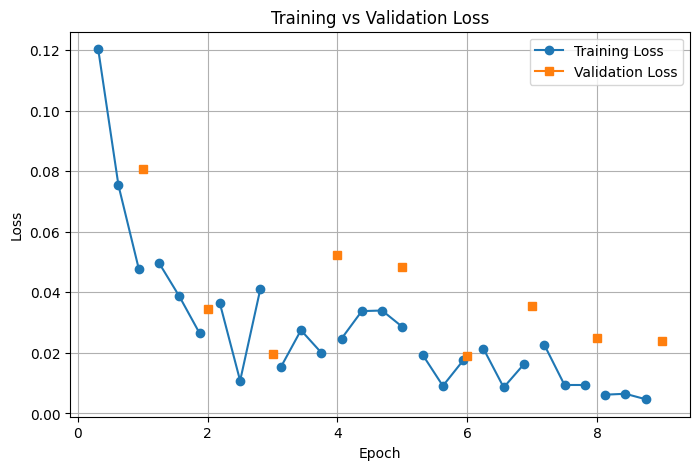

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract training logs
log_history = trainer.state.log_history

# Convert to DataFrame
df_logs = pd.DataFrame(log_history)[["epoch", "total_flos", "loss", "eval_loss"]]
df_logs = df_logs.dropna(how="all")

# Display available keys
print(df_logs.head())

plt.figure(figsize=(8, 5))
plt.plot(df_logs["epoch"], df_logs["loss"], label="Training Loss", marker="o")
plt.plot(df_logs["epoch"], df_logs["eval_loss"], label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [4]:
predictions = trainer.predict(valid_dataset)
preds = predictions.predictions.flatten()  # Flatten if single-output regression
labels = predictions.label_ids

# Convert to DataFrame
df_results = pd.DataFrame({"Actual": labels, "Predicted": preds})

# Display first few rows
print(df_results.head())

     Actual  Predicted
0  0.591293   0.391773
1  0.159817   0.282852
2  0.250225   0.355311
3  0.255689   0.377828
4  0.186420   0.165226


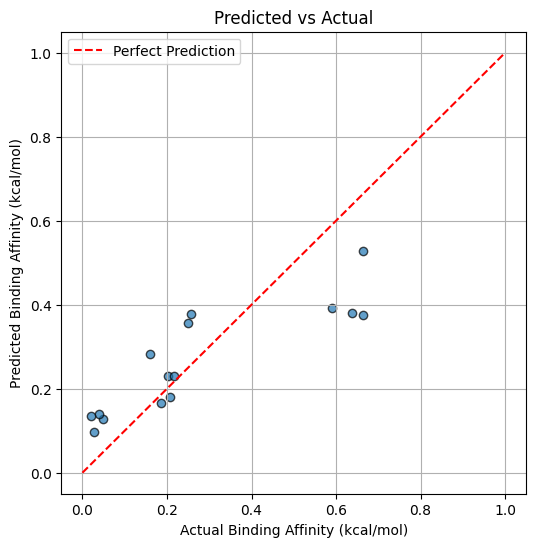

SignificanceResult(statistic=np.float64(0.9178571428571428), pvalue=np.float64(1.4176968515006258e-06))

In [5]:
plt.figure(figsize=(6, 6))
plt.scatter(labels, preds, alpha=0.7, edgecolors="k")
plt.plot([0, 1], [0, 1], "r--", label="Perfect Prediction")  # Identity line
plt.xlabel("Actual Binding Affinity (kcal/mol)")
plt.ylabel("Predicted Binding Affinity (kcal/mol)")
plt.title("Predicted vs Actual")
plt.legend()
plt.grid()
plt.show()

from scipy.stats import spearmanr

spearmanr(labels, preds)

In [7]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from huggingface_hub import HfApi, HfFolder

model_name = "alex-apoha/esm_finetuned"  # Change to your Hugging Face username and desired model name
model.push_to_hub(model_name)
tokenizer.push_to_hub(model_name)

model.safetensors:  48%|████▊     | 286M/595M [00:18<00:04, 65.5MB/s]
model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]
model.safetensors:   2%|▏         | 12.4M/595M [00:00<00:05, 116MB/s]
model.safetensors:   4%|▍         | 24.0M/595M [00:00<00:05, 104MB/s]
model.safetensors:   6%|▌         | 34.4M/595M [00:00<00:07, 75.4MB/s]
model.safetensors:   8%|▊         | 48.0M/595M [00:00<00:07, 75.4MB/s]
model.safetensors:  11%|█         | 64.0M/595M [00:00<00:07, 73.9MB/s]
model.safetensors:  13%|█▎        | 80.0M/595M [00:01<00:06, 74.2MB/s]
model.safetensors:  16%|█▌        | 96.0M/595M [00:01<00:06, 77.0MB/s]
model.safetensors:  19%|█▉        | 112M/595M [00:01<00:06, 76.9MB/s] 
model.safetensors:  22%|██▏       | 128M/595M [00:01<00:06, 76.7MB/s]
model.safetensors:  24%|██▍       | 144M/595M [00:02<00:08, 53.6MB/s]
model.safetensors:  27%|██▋       | 160M/595M [00:02<00:07, 58.7MB/s]
model.safetensors:  30%|██▉       | 176M/595M [00:02<00:06, 61.5MB/s]
model.safetensors:  32

CommitInfo(commit_url='https://huggingface.co/alex-apoha/esm_finetuned/commit/338f201734f56a10d576326b93d9119b1e0cccfc', commit_message='Upload tokenizer', commit_description='', oid='338f201734f56a10d576326b93d9119b1e0cccfc', pr_url=None, repo_url=RepoUrl('https://huggingface.co/alex-apoha/esm_finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='alex-apoha/esm_finetuned'), pr_revision=None, pr_num=None)

In [8]:
from huggingface_hub import HfApi

model_name = "alex-apoha/esm_finetuned"  # Change to your username/model name

# Push model
print(f"\n🚀 Pushing model to Hugging Face Hub: {model_name}")
trainer.push_to_hub(model_name)
print("✅ Model successfully pushed to Hugging Face Hub!")



🚀 Pushing model to Hugging Face Hub: alex-apoha/esm_finetuned



training_args.bin: 100%|██████████| 5.30k/5.30k [00:00<00:00, 91.0kB/s]


✅ Model successfully pushed to Hugging Face Hub!


In [10]:
from huggingface_hub import Repository

repo_dir = "./esm_finetuned"
repo = Repository(repo_dir, clone_from="alex-apoha/esm_finetuned")

# Add and commit everything
repo.git_add()
repo.git_commit("Updating fine-tuned model with latest weights")
repo.git_push()

/home/sagemaker-user/.conda/envs/esm-env/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)


OSError: Looks like you do not have git-lfs installed, please install. You can install from https://git-lfs.github.com/. Then run `git lfs install` (you only have to do this once).